# Word 2 Vec

The following notebook walks you through using word2vec from the Python Gensim package. Word2Vec is a Word Embedding Model (WEM) and helps to find how specific words are used in a given text. 

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED. 

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:


- **re:** Provides regular expression matching operations similar to those found in Perl.
- **string:** Contains a number of functions to process standard Python strings.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **warnings:** Allows for the manipulation of warning messages in Python.
- **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter.
- **spacy:** A library for advanced Natural Language Processing in Python and Cython.
- **sklearn:** Simple and efficient tools for data mining and data analysis built on NumPy, SciPy, and matplotlib.
- **matplotlib:** Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.
- **collections:** implements specialized container datatypes providing alternatives to Python's general purpose built-in containers, dict, list, set, and tuple.
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.


In [2]:
import re
from os.path import join, isfile, splitext
import string
import nltk
from nltk.corpus import stopwords
import glob
import numpy as np
import pandas as pd
import warnings
from pprint import pprint
import spacy
from sklearn.decomposition import PCA
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import Counter

import gensim
import gensim.corpora as corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import doc2vec
from gensim.models.phrases import Phrases, Phraser

This will ignore deprecation, user, and future warnings. All the warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
warnings.filterwarnings("ignore", category=UserWarning,
                        module = "gensim", lineno = 598)

warnings.filterwarnings("ignore", category=FutureWarning,
                        module = "gensim", lineno = 737)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Getting your data

#### File paths
Here we are saving as variables different file paths that we need in our code. We do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later. 

First we use the `os` package above to find our `[HOME]` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your "home" directory, so no changes are needed.

Next, we combine the `homePath` variable with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one file. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` variable to other folder names that lead to a folder where we will want to save any output generated by this code. We will change the file names for our output in other cells as we need to down below. We save this file path as the variable `dataResults`.

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. Much like the file path variables above, we do this so you do not need to make as many changes later.

**source**<br>
First, we need to decide if we want our code to read all the files in a directory or just a single file. If we want all the files in a directory then we set `source` equal to `"*"`. This means 'all' and will be added to the file type later in the code. If you want a single file change `"*"` to the file name without the ".txt" or ".csv" or ".json" at the end. So if you have a file named "myFile.txt" you would set `source` equal to `"myFile"` without the ".txt".

**fileType**<br>
Now we need to determine what file type our data is. You can find this by the file extension at the end of your file's name. Right now we can only read in plain text files which end in ".txt" (minus the quotes), comma separated value files which end in ".csv", and JSON files which end in ".json". So where it says `fileType =` inside the double quotes you need to put either `".txt"`, `".csv"`, or `".json"` depending on what your data file type is.

**docLevel**<br>
The `docLevel` variable is only for file types of ".txt" so if you have a ".csv" or ".json" you want to set it to **False** or it will cause problems in other parts of the code later since we do not keep track of file names for the ".csv" and ".json" files. If your data is in ".txt" format, then you need to determine if you want to chunk your corpus by line or by document.

We do this in case your data is a single ".txt" file. The LDA algorithm needs to have multiple chunks to accurately weigh and order words into topics. If you have multiple documents then the documents themselves are the chunks. If you have a single document, then we need to create chunks, and we do this by spliting the document up by line and each line is a separate chunk.

If you want to separate by document, then set docLevel equal to **True**. If you want to separate a line at a time and have each line be it's own entity or 'chunk' then set `docLevel` equal to **False**. If you set `source` equal to `"*"` then you will want to set `docLevel` equal to **True**. If you set `source` equal to a specific file name, then you will want to set `docLevel` equal to **False**.

**nltkStop**<br>
The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**.

**customStop**<br>
`customStop` is for if you have a .txt file that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do *NOT* need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopWords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**.

**spacyLem**<br>
`spacyLem` is where we decide if we want to use the spaCy package lemmatization function. What is lemmatization? Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, and identified by the word's lemma, or dictionary form. In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, where as stemming does not take the context of the word into account. For example, if we lemmatize the word "running" or "ran" it will become the word "run". If we stem the word "running" most stemmers will convert it to "runn" only removing the "ing" and leaving the second "n". Stemming will also change "police" and "policy" both to "polic" and they will be considered the same word by the LDA script. The lemmatizer will leave both words as "police" and "policy". This is useful and recommended for topic modeling as it allows the algorithm to just consider "walk" instead of "walking", "walked", and "walk" and thereby can increase the accuracy of your results. To use the spacy lemmatizer set `spacyLem` equal to **True**. If you do not wish to use the lemmatizer set `spacyLem` equal to **False**.

**stopLang**<br>
Now we choose the language we will be using for the nltk stopwords list. If you need a different language, simply change 'english' (keep the quotes) in the `stopLang` variable to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you need to see the list of available languages in nltk simply remove the `#` from in front of `#print(" ".join(stopwords.fileids()))` on the last line and run the cell. A list of available languages will print out.

**lemLang**<br>
Now we choose the language for our lemmatizer. The languages available for spacy include the list below and the abbreviation spacy uses for that language:

- **English:** en
- **Spanish:** es
- **German:** de
- **French:** fr
- **Italian:** it
- **Portuguese:** pt
- **Dutch:** nl
- **Multi-Language:** xx

To choose a language simply type the two letter code following the angliscized language name in the list above. So for Spanish it would be `'es'` (with the quotes) and for German `'de'` and so on.

**stopWords, docs, tweets**<br>
The `stopWords =[]` variable is simply an empty list. This is where the words from the nltk stopword list or your custom stopword list or both combined or neither (depending on what you decide) will reside later on. You do not need to do anything to this line of code.

The docs and tweets variables do not need to have anything done as they are also empty lists that may have elements added to them later.

In [5]:
source = "*"
fileType = ".txt"
docLevel = True
nltkStop = True
customStop = False
spacyLem = True
stopLang = 'english'
lemLang = 'en'
stopWords = []
docs = []
tweets = []

#print(" ".join(stopwords.fileids()))

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the NLTK stopwords list to the empty list named `stopWords`.

You already chose your desired language above, so you do not need to do that now. 

If you need to add a few more words to the `stopWords` list that are specific to your dataset (such as common names or phrases that may make your results inaccurate), then add those to the `stopWords.extend(['would', 'said', 'says', 'also'])` part of the code in the square brackets with single quotes around each word and separated by a comma.

In [6]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))

    stopWords.extend(['would', 'said', 'says', 'also', 'let', 'not'])

#### Add own stopword list

Here is where your own stopword list is added if you selected **True** in `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [7]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-master", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Reading in .txt files
The code below reads in text files if you chose `fileType =".txt"` above. It can do this in two ways. We can read in an entire directory, or we can read in a single file and it will do those based on what you chose for `source` above. Then it will chunk your data, either by document or by line, and this will depend on what you chose for `docLevel` above. 

In [8]:
if fileType == ".txt":
    paths = glob.glob(os.path.join(dataHome, "shakespeareDated",source + fileType))
    for path in paths:
        with open(path, "r", encoding = 'ISO-8859-1') as file:
             # skip hidden file
            if path.startswith('.'):
                continue
            if docLevel is True:
                docs.append(file.read().strip('\n').splitlines())
            else:
                for line in file:
                    stripLine = line.strip()
                    if len(stripLine) == 0:
                        continue
                    docs.append(stripLine.split())

### Reading in .csv files

If you chose `".csv"` as your `fileType` up above, then the code below reads in ".csv" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".csv" file using the Pandas `read_csv` function, we need to concatenate the ".csv" files if there are multiple. Because of this it is important that your ".csv" files have and identical column count and each column has identical header names or you will get errors. If you have a single ".csv" file then you should be fine for this step. We assign this process to the variable `cc_df` so we can use it later.

Now we convert our `cc_df` to a pandas dataframe. This allows for easier manipulation of the data in the next step.

The last line is where you will name the column you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. Here we are converting the column labeled `['text']` to a list. If you wished to convert the first column to a list the code would look like this: `tweets = cc_df[0].values.tolist()`. Notice the number is 0 and not 1. This is because Python begins counting at 0.

In [9]:
if fileType == ".csv":
    all_files = glob.glob(os.path.join(dataHome, "twitter", source + fileType))     
    df_all = (pd.read_csv(f) for f in all_files)
    cc_df = pd.concat(df_all, ignore_index=True)
    cc_df = pd.DataFrame(cc_df, dtype = 'str')
    tweets = cc_df['text'].values.tolist()

### Reading in JSON files

If you chose `".json"` as your `fileType` up above, then the code below reads in ".json" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".json" file we need to append the ".json" files if there are multiple. Because of this it is important that your ".json" files have identical keys or you will get errors. If you have a single ".json" file then you should be fine for this step. 

Next we append the contents to our empty `tweets=[]` list we created above. Then we convert our tweets list to a dataframe so we can more easily manipulate the data. Each key from the ".json" content is converted to a header in the dataframe and the values associated with that key now become rows in the corresponding column.

In the last line we now convert one column in our dataframe to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. Here we are converting the column labeled `['text']` to a list. If you wished to convert the first column to a list the code would look like this: `tweets = df[0].tolist()`. Notice the number is 0 and not 1. This is because Python begins counting at 0.

In [10]:
if fileType == ".json":
    for filename in glob.glob(os.path.join(dataHome, "twitter", "JSON", source + fileType)):
        with open(filename, 'r', encoding = "utf-8") as jsonData:
            for line in jsonData:
                tweets.append(json.loads(line))
    df = pd.DataFrame(tweets)
    tweets = df['text'].tolist()

### Data variable

Now we need to change our variable containing our data (either docs or tweets from above) to the variable `data` since this is the variable used going forward and it saves you from having to switch between `tweets` and `docs` later in the code. If you read in ".csv" or ".json" files then your data is saved in the `tweets` list and if you read in ".txt" files then it is in the `docs` list. This code says if the length of the `docs` list is greater than 0 then assign `docs` to the variable data. If the length of `tweets` greater than 0 then assign `tweets` to the variable `data`.

If your data was in `tweets` then it most likely needs some additional cleaning. So the next chunk of code removes URLS and new line characters from the `data` variable if the length of `tweets` is greater than 0.

The last line prints out the first chunk of data in our collection, in this case the first item. This can be 1 whole text file or 1 line depending on your previous choices.

In [11]:
if len(docs) > 0:
    data = docs
else:
    if len(tweets) > 0:
        data = tweets
        # Remove Urls
        data = [re.sub(r'http\S+', '', sent) for sent in data]
        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]

pprint(data[:1])

[[' Cease to persuade, my loving Proteus.',
  ' Home-keeping youth have ever homely wits.',
  " Were 't not affection chains thy tender days",
  ' To the sweet glances of thy honoured love,',
  ' I rather would entreat thy company',
  ' To see the wonders of the world abroad',
  ' Than, living dully sluggardized at home,',
  ' Wear out thy youth with shapeless idleness.',
  ' But since thou love, love still and thrive therein,',
  ' Even as I would when I to love begin.',
  '',
  ' Wilt thou be gone? Sweet Valentine, adieu.',
  ' Think on thy Proteus when thou happily see',
  ' Some rare noteworthy object in thy travel.',
  ' Wish me partaker in thy happiness',
  ' When thou dost meet good hap; and in thy danger,',
  ' If ever danger do environ thee,',
  ' Commend thy grievance to my holy prayers,',
  ' For I will be thy beadsman, Valentine.',
  '',
  ' And on a love-book pray for my success?',
  '',
  " Upon some book I love I'll pray for thee.",
  '',
  " That's on some shallow story

### Tokenizing

This block of code separates each chunk of text into a list of individual words. In the process it also lower cases all the words and removes punctuation. If you wish to keep the punctuation change `deacc = True` to `deacc = False`.

In [12]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dataWords = list(sentToWords(data))

print(dataWords[:1])

[['cease', 'to', 'persuade', 'my', 'loving', 'proteus', 'home', 'keeping', 'youth', 'have', 'ever', 'homely', 'wits', 'were', 'not', 'affection', 'chains', 'thy', 'tender', 'days', 'to', 'the', 'sweet', 'glances', 'of', 'thy', 'honoured', 'love', 'rather', 'would', 'entreat', 'thy', 'company', 'to', 'see', 'the', 'wonders', 'of', 'the', 'world', 'abroad', 'than', 'living', 'dully', 'sluggardized', 'at', 'home', 'wear', 'out', 'thy', 'youth', 'with', 'shapeless', 'idleness', 'but', 'since', 'thou', 'love', 'love', 'still', 'and', 'thrive', 'therein', 'even', 'as', 'would', 'when', 'to', 'love', 'begin', 'wilt', 'thou', 'be', 'gone', 'sweet', 'valentine', 'adieu', 'think', 'on', 'thy', 'proteus', 'when', 'thou', 'happily', 'see', 'some', 'rare', 'noteworthy', 'object', 'in', 'thy', 'travel', 'wish', 'me', 'partaker', 'in', 'thy', 'happiness', 'when', 'thou', 'dost', 'meet', 'good', 'hap', 'and', 'in', 'thy', 'danger', 'if', 'ever', 'danger', 'do', 'environ', 'thee', 'commend', 'thy', 'gr

### Find Bigrams and Trigrams

This code will most likely not need to be adjusted. It creates a model of bigrams and trigrams in your dataset that occur frequently and then connects them with an underscore so the LDA algorithm will later consider them as one word. This is a good idea for items like 'new york' or 'new zealand' or 'Ho Chi Minh'. If we do not combine these frequently occuring phrases then 'new' and 'york' will be considered independently and give us less accurate results. 

Right now we have a `min_count` of 5 and a `threshold` of 100. The `min_count` is simply the minimum number of times the bigram or trigram needs to occur in order to be combined with an underscore. The `threshold` is a score that the bigram or trigram needs to exceed in order to be combined with an underscore. The score is determined by using this formula: (bigram_count - min_count)\*vocab_count/(wordA_count \* wordB_count). So let's say we have the bigram "good_lord" and it appears 30 times in a text of 10,000 words where "good" appears 60 times total and "lord" appears 40. With our `min_count` set to 5 we get the following: (30 - 5)\*10000/(60 \* 40) = 104.167 which means since our `threshold` is set to 100 "good_lord" will be combined with an underscore and made into a bigram. If the resulting score is above your `threshold` then the ngram is considered important enough to combine with an underscore and will be viewed as one word for the LDA scoring later. Therefore, if you increase the `threshold`, you will get fewer bigrams and trigrams. If our threshold was set to 110, then "good" and "lord" would not be combined into "good_lord".

The Phraser function takes the model you built with the Phrases function and cuts down memory consumption of Phrases, by discarding model state not strictly needed for the bigram detection task.

Lastly, we take a look at the ngrams created from the first item in our dataset only, so the results are for only one chunk, not the whole dataset. We do this by counting the number of words that contain an underscore as this is used to connect the words in the ngram together. **NOTE:** The output is only to test if the ngrams work so you will probably see ngrams containing stopwords. We will create a few functions next and then apply them to remove stopwords, create bigrams, and lemmatize the chunk.

In [13]:
# Build the bigram and trigram models
bigram = Phrases(dataWords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[dataWords], threshold=100)  

# Removes model state from Phrases thereby reducing memory use.
bigramMod = Phraser(bigram)
trigramMod = Phraser(trigram)

# See bigram/trigram example
testNgram = trigramMod[bigramMod[dataWords[0]]]
char = "_"
nGrams = [s for s in testNgram if char in s]
            
pprint(Counter(nGrams))

Counter({'thousand_times': 4,
         'good_morrow': 4,
         'chamber_window': 3,
         'fie_fie': 2,
         'an_ass': 2,
         'fast_asleep': 2,
         'gav_st': 1,
         'hard_favored': 1,
         'twenty_thousand': 1,
         'ill_favored': 1,
         'stand_aside': 1,
         'looking_glass': 1,
         'amen_amen': 1})


### Functions
We need to create a function in order to stem and tokenize our data. Any time you see `def` that means we are **DE**claring a **F**unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters required by the function. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to call the function without having to write out all the code in the function every time you wish to perform that task.

### Some functions

Below are functions we are creating that perform certain tasks. First we are creating a function to remove the stopwords that are in our stopword list we created previously. Then we create functions to apply our bigram and trigram code from above. 

Lastly, if you set `spacyLem` equal to **True** above then we will create the `lemmatization` function. If you set it equal to **False** then it will not create the function.

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]


if spacyLem is True:
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        textsOut = []
        lemmaPOS = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            textsOut.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            lemmaPOS.append([token.text and token.lemma_ and token.pos_ for token in doc if token.pos_ in allowed_postags])
        return textsOut
        print(lemmaPOS[:10])

Now we apply the functions. There are really only two parts where you may need to make changes and they are in the lines `dataWordsNgrams = makeBigrams(dataWordsNostops)` and `nlp = spacy.load(lemLang, disable=\['parser', 'ner'\])`.

The `dataWordsNgrams` variable is where you will change between either using the `makeBigrams` or `makeTrigrams` functions above. If you only want bigrams, then keep the code as it is. If you want both bigrams and trigrams to be considered in your topic modeling, then change the `makeBigrams` part to `makeTrigrams` and it will now calculate both bigrams and trigrams. 


Adjustments to the other line that might need changes mentioned above may only be necessary if you previously set `spacyLem` equal to **True**. Even if you set it to **True** you may still not need to make changes. The line of code you may want to change is `nlp = spacy.load('lemLang', disable=\['parser', 'ner'\])` and is where you can disable the parser and named entity recognizer (ner). 

If you wish for your words to be parsed simply remove `'parser'` from the `disable=` bracket. Same for `ner`. If you wish to use both the parser and ner then just remove the `, disable=\['parser', 'ner'\]` entirely (including the preceding comma), but leave the closing parantheses. The reason we disable to 'parser' and 'ner' is because they slow down the lemmatization process and are not necessary to lemmatize our dataset.

Lastly, we print out the ngrams we find in the first chunk (document or line) of our data. Notice there are no trigrams included. This is because we applied only the `makeBigrams` function from above. If we had applied the `makeTrigrams` function we would have both bigrams and trigrams. Feel free to change this in the code as described above. If we set `spacyLem` equal to **True** then we will get the first 10 words, their lemmatized form (which sometimes is identical to the word being lemmatized), with their parts of speech tagging from the `lemmatization` function above. Below this is a list of the lemmatized bigrams from the first chunk of our data. If we set it to **False** then we will get bigrams from the first chunk that have not been lemmatized.

In [15]:
# Remove Stop Words
dataWordsNostops = removeStopwords(dataWords)

# Form Bigrams
dataWordsNgrams = makeBigrams(dataWordsNostops)

if spacyLem is True:
    # Initialize spacy language model, eliminating the parser and ner components
    nlp = spacy.load(lemLang, disable=['parser', 'ner'])
    
    # Do lemmatization tagging only noun, adj, vb, adv
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    dataLemmatized = lemmatization(dataWordsNgrams, allowed_postags=allowed_postags)
    lemmaPOS = []
    for sent in dataLemmatized:
        lemmaNLP = nlp(" ".join(sent))
        for token in lemmaNLP:
            lemmaPOS.append([token.text, token.lemma_, token.pos_])
    print(lemmaPOS[:10])
    

    # Find ngrams and count number of times they occur
    dataNgrams = [s for s in dataLemmatized[0] if char in s]
    
else:
    dataNgrams = [s for s in dataWordsNgrams[0] if char in s]
print(Counter(dataNgrams))

[['cease', 'cease', 'VERB'], ['persuade', 'persuade', 'NOUN'], ['love', 'love', 'NOUN'], ['proteus', 'proteus', 'NOUN'], ['home', 'home', 'NOUN'], ['keep', 'keep', 'VERB'], ['youth', 'youth', 'NOUN'], ['ever', 'ever', 'ADV'], ['homely', 'homely', 'ADV'], ['wit', 'wit', 'ADP']]
Counter({'good_morrow': 4, 'chamber_window': 3, 'fast_asleep': 2, 'gav_st': 1, 'fie_fie': 1, 'ill_favore': 1, 'stand_aside': 1, 'looking_glass': 1, 'amen_aman': 1})


#### Getting Information

Now we want to get some information about our corpus now that it is cleaned as some words have been removed, some may have been combined into one word by our bigram/trigram function, and others may have been lemmatized. We need some word counts as these will help inform some of our parameters for the word2vec function later.

It is important to note that we have an `if` `else` statement. This is used so that you will not need to make adjustments if you chose not to use the spacy lemmatizer above.

The first thing in both the `if` and the `else` part is to save our cleaned corpus as the variable `texts`.

However, our cleaned corpus is a list of lists, and our `Counter` function from the `collections` package needs everything in a single list. So we combine our list of lists into a single list in the `tokens = sum(texts, [])` part of the code. 

Next, we import the `Counter` function from the `collections` package and then use it to count how often every word appears in our cleaned and finalized list of words and ngrams. We assign this to the variable `count`.

Now we print out the number of total words (`print(sum(count.values()))`), followed by the number of unique words (`print(len(count))`), and ending with the top 1000 words based on frequency (`print(count.most_common(1000))`). You will want to change this number based on the size of your dataset.  

In [16]:
if spacyLem is True:
    # Create Corpus
    texts = dataLemmatized
    tokens = sum(texts, [])
else:
    # Create Corpus
    texts = dataWordsNgrams
    tokens = sum(texts, [])

from collections import Counter
count = Counter(tokens)
print(sum(count.values()))
print(len(count))
print(count.most_common(1000))

360241
16149
[('thou', 5298), ('come', 3630), ('shall', 3539), ('good', 3037), ('lord', 3037), ('man', 2873), ('make', 2840), ('sir', 2505), ('go', 2497), ('love', 2479), ('know', 2308), ('well', 2272), ('may', 2156), ('see', 2056), ('hath', 1892), ('give', 1889), ('say', 1741), ('take', 1619), ('king', 1568), ('speak', 1544), ('must', 1460), ('think', 1429), ('tis', 1398), ('tell', 1351), ('hear', 1294), ('never', 1211), ('time', 1171), ('heart', 1146), ('look', 1142), ('hand', 1118), ('father', 1087), ('great', 1024), ('much', 1016), ('eye', 1009), ('mine', 995), ('god', 988), ('leave', 932), ('day', 928), ('bear', 907), ('word', 907), ('life', 906), ('death', 889), ('art', 885), ('friend', 875), ('call', 872), ('doth', 849), ('master', 844), ('stand', 817), ('lie', 801), ('not', 799), ('fair', 783), ('live', 782), ('true', 777), ('sweet', 776), ('find', 776), ('son', 772), ('lady', 770), ('pray', 769), ('fear', 762), ('thus', 751), ('away', 738), ('yet', 724), ('name', 718), ('honou

### Build vocabulary and train the model
Now we pass our corpus through the `Word2Vec` function. Then we call the function `train` to "train" `Word2Vec` using our corpus. The parameters in the `Word2Vec` function may need to be changed depending on your needs, your dataset, and the results of the word counts from the previous cell of code. The parameters do the following:

- **texts:** Is passing our variable above and letting Word2Vec know that this is what we wish to use for our dataset.
- **size:** The size of the dense vector to represent each token or word (i.e. the context or neighboring words). If you have limited data, then size should be a much smaller value since you would only have so many unique neighbors for a given word. If you have lots of data, its good to experiment with various sizes.
- **window:** The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left or the right, then, some neighbors would not be considered as being related to the target word. In theory, a smaller window should give you terms that are more related.
- **min_count:** Minimum number of times a word needs to appear to be counted. This should be adjusted based on your dataset.
- **workers:** How many cores to use on a machine with multiple cores.
- **sg:** Training algorithm: 1 for skip-gram; otherwise continuous bag-of-words (CBOW).  In the continuous bag-of-words architecture, the model predicts the current word from a window of surrounding context words. The order of context words does not influence prediction (bag-of-words assumption). In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of context words. The skip-gram architecture weighs nearby context words more heavily than more distant context words. CBOW is faster while skip-gram is slower but does a better job for infrequent words. 
- **seed:** Sets the seed for reproducibility.

In [17]:
# build vocabulary and train model

model = gensim.models.Word2Vec(
    texts,
    size=100,
    window=10,
    min_count=60,
    workers=1,
    sg = 1,
    seed = 42)
model.train(texts, total_examples=len(texts), epochs=10)

(2180897, 3602410)

### Let's find some word relationships
First, we have assigned the name of the output .csv file to the variable `w2vCSVfile`. You may wish to change the name of the file to better match your data.

Now we choose a word of interest and see what other words are associated with that word in the text. Change the word in quotes after `w1` to change the word. You may also want to change the `topn` value as this determines how many of the top words you will get in the .csv file output.

The ouput you see shows the top ten words ranked by proximity. This is because what `Word2Vec` does is turn each word into a vector and then run cosine similarity on the vectors when two words are compared. The numbers you see are the cosine similarity scores of our word of interest with the corresponding word in the table. They are listed from highest to lowest (most similar to least).

In [18]:
w2vCSVfile = 'word2vec.csv'
w1 = "woman"
topn = 30

wtv = model.wv.most_similar(positive=[w1], topn = topn)
df = pd.DataFrame(wtv)
df.to_csv(os.path.join(dataResults, w2vCSVfile))
dfG = df[:10]
dfG

,0,1
0,honest,0.558075
1,man,0.535305
2,wife,0.501171
3,well,0.469651
4,honesty,0.454334
5,think,0.428029
6,husband,0.423922
7,none,0.421436
8,make,0.417608
9,ever,0.417336


Here we can compare two words to each other to see how similar they are in their usage. Just change the words in quotes to the ones you want to compare.

In [19]:
model.wv.similarity(w1 = 'king', w2 = 'queen')

0.4766975

Now convert our results in the `df` variable from above to a list so we can plot the points of our result in a scatter plot later. There should be no need to make changes here.

In [20]:
dfLst = df[0].tolist()
dfLst.append(w1)

Here we create a function that uses Principal Component Analysis (PCA) for dimensionality reduction so that our word vectors can be plotted in a 2D space. We use the PCA function from the `sklearn` package to accomplish the PCA dimensionality reduction. The only change to make is to the variable `color`. This will determine the color of the dots in the scatter plot.

In [21]:
# Variable
color = 'red'

# Function
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(9,9))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=color)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

Now we apply the function to our `model` from above and the list we made from our `df` variable and assigned to the variable `dfLst`. There should be no need to make changes here.

<IPython.core.display.Javascript object>


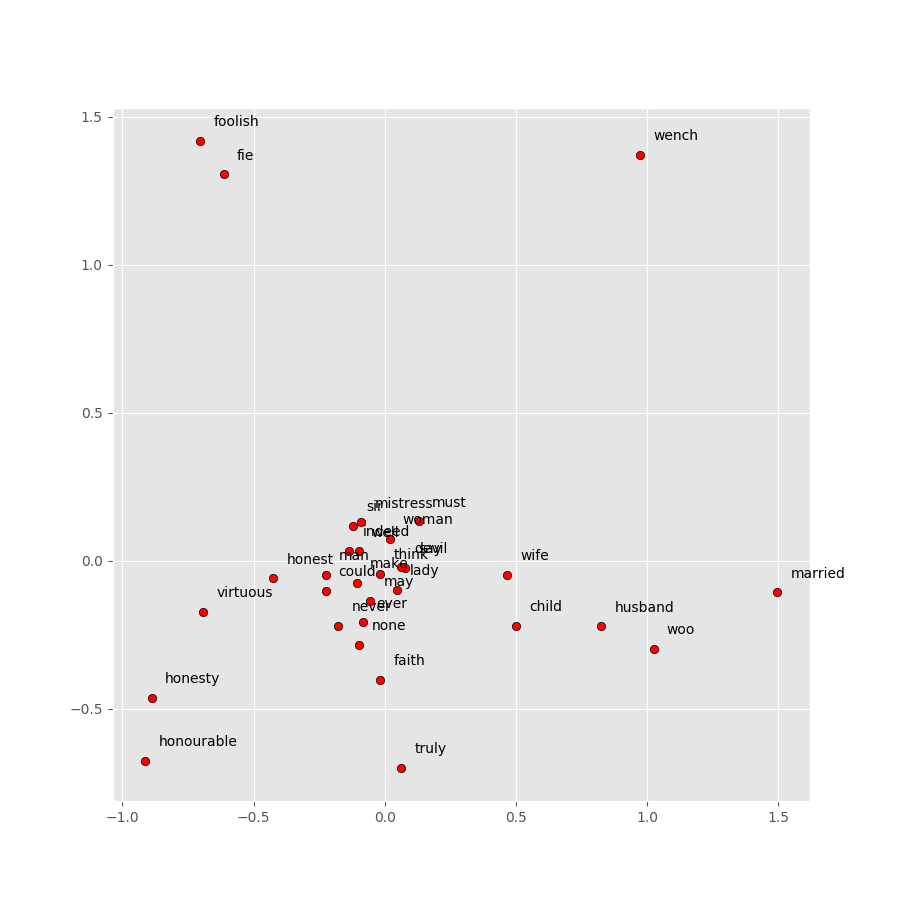

In [22]:
display_pca_scatterplot(model, dfLst)

## VOILA!!

This code was adapted from Kavita Ganesan at [http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFnQmc9KjUI](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFnQmc9KjUI). Accessed 02/05/2019. The display_pca_scatterplot function was taken entirley from [https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html](https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html) and was accessed on 07/18/2019.